In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
class StochasticSIR():
    def __init__(self, inits, params, t0=0):
        
        self.gam, self.beta, self.mu, self.eta = params
        self.inits = inits
        
        self.R0 = self.beta/(self.gam + self.mu)
        
        self.model = [inits] # for storing population counts at each time step
        self.time = [t0]     # time list
        self.extincts = []   # list for storing when extictions happen
        
    def get_event(self, pops):
        X, Y, Z = pops
        N = sum(pops)
        
        birthrate = self.mu*N
        transrate = self.beta*X*Y/N
        recorate  = self.gam*Y
        deathX    = self.mu*X
        deathY    = self.mu*Y
        deathZ    = self.mu*Z
        importrate = self.eta*np.sqrt(N) 
        
        rates = np.array([birthrate, transrate, recorate, deathX, deathY, deathZ, importrate])
        dt = -np.log(np.random.random())/np.sum(rates)
        P = np.random.random()*np.sum(rates)
        E = np.min(np.where(np.cumsum(rates) >= P))
        
        return E, dt
    
    def update(self, event, pops):
        X, Y, Z = pops
        if event == 0:
            X += 1
        elif event == 1:
            X -= 1
            Y += 1
        elif event == 2:
            Y -= 1
            Z += 1
        elif event == 3:
            X -= 1
        elif event == 4:
            Y -= 1
        elif event == 5:
            Z -= 1
        elif event == 6:
            Y += 1
            X -= 1
            
        return [X, Y, Z]
    
    def simulate(self, maxT):
        pops = self.model[-1]
        t = self.time[-1]
        while t < maxT:
            if self.model[-1][1] <= 0:
                #print(f"Disease eradicated at t = {t:.2f}")
                self.extincts.append(t)
                
            event, dt = self.get_event(pops)
            
            pops = self.update(event, pops)
            t += dt
            
            self.model.append(pops)
            self.time.append(t)

    def burn_in(self, T):
        self.simulate(T)
        self.model = [self.model[-1]]
        self.time = [self.time[-1]]
        self.extincts = []
        
            
    def unpack(self):
        """ Get X, Y, Z as arrays"""
        
        XYZ = np.zeros((len(self.time), 3))
        for i in range(len(XYZ)):
            XYZ[i, 0] = self.model[i][0]
            XYZ[i, 1] = self.model[i][1]
            XYZ[i, 2] = self.model[i][2]
        
        return XYZ
    
    def get_end_equilibrium(self):
        R0 = self.beta/(self.mu + self.gam)
        N = sum(self.model[0])
        
        S_eq = 1.0/R0
        I_eq = self.mu/self.beta*(R0 - 1)
        R_eq = 1.0 - S_eq - I_eq
        
        return (S_eq*N, I_eq*N, R_eq*N)
    
    def reset(self):
        self.model = [self.inits]
        self.time = [self.time[0]]
        self.extincts = []
        
    def solve_deterministic(self, func, tspan, inits=None):
        p = (self.gam, self.beta, self.mu)
        
        if inits is not None:
            u0 = inits
        else:
            u0 = np.array(self.inits) / sum(self.inits)
            
        
        sol = solve_ivp(func, tspan, u0, args=p, dense_output=True)
        
        return sol
    
    def plot(self, tspan=None, var=None, **kwargs):
        
        time = np.array(model.time)
        idxs = np.arange(len(time))
        
        if tspan is not None:
            idxs = np.where((time >= tspan[0]) & (time <= tspan[1]))[0]
            time = time[idxs]
            
        sol = model.unpack()
        if var is not None:
            tempsol = sol[idxs,:]
            sol = tempsol[:,var]
        else:
            sol = sol[idxs,:]
            
        plt.plot(time, sol, **kwargs)


array([[ 76.6336    , -30.936251  ],
       [-30.936251  ,  75.22083582]])

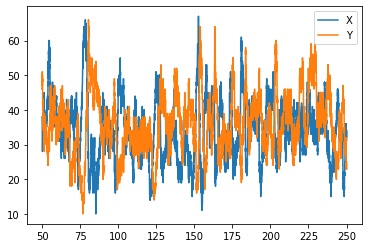

In [117]:
N = 500
Y0 = 1
X0 = N - Y0
Z0 = 0

inits = [X0, Y0, Z0]

mu = 1/15
gam = 0.7
beta = 10.0
eta = 0.02

params = [gam, beta, mu, eta]

model = StochasticSIR(inits, params)
model.burn_in(50)
model.simulate(250)
model.plot(var=[0, 1])
plt.legend(["X", "Y", "Z"])
sol = model.unpack()
np.cov(sol[:,0], sol[:,1])

# 1: Variability

     Variability between simulations. The most obvious element of any stochastic model
    is that different simulations give rise to different outcomes. This implies that although
    the general statistical properties (such as the mean and the variance) may be
    accurately predicted, it is generally impossible to predetermine the precise disease
    prevalence at any given point in the future.

In [202]:
N = 100
Y0 = 1
X0 = N - Y0
Z0 = 0

inits = [X0, Y0, Z0]

mu = 1/75
gam = 1.0
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

model = StochasticSIR(inits, params)

In [203]:
N_iters = 100

end_vals = np.zeros((N_iters, 3))
for i in range(N_iters):
    model.simulate(100)
    end_vals[i,:] = model.model[-1]
    model.reset()

In [211]:
means = np.mean(end_vals, axis=0)

[29.34  1.03 68.37]


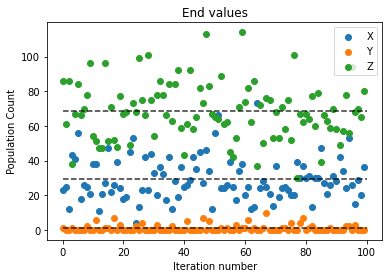

In [223]:
plt.scatter(range(0, N_iters), end_vals[:,0])
plt.scatter(range(0, N_iters), end_vals[:,1])
plt.scatter(range(0, N_iters), end_vals[:,2])
plt.hlines(means, 0, N_iters, alpha=0.8, linestyle="--", color="black")
plt.legend(["X", "Y", "Z"])
plt.xlabel("Iteration number")
plt.ylabel("Population Count")
plt.title("End values")
plt.savefig("figures/endvals.svg")
print(means)

# 2: Negative co-variances

    Variances and covariances. The continual perturbations caused by the random nature
    of stochastic equations leads to variation in the prevalence of disease and the number
    of susceptibles. Additionally, the interaction between stochasticity and deterministic
    dynamics generally causes negative covariance between the numbers of infectious
    and susceptible individuals, which in turn can cause the mean population levels
    (X, Y) to deviate from the deterministic equilibria.

In [120]:
Ns = np.arange(50, 1050, 50)
mu = 1/75
gam = 0.7
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

cov = np.zeros((len(Ns), 2, 2))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0

    inits = [X0, Y0, Z0]
    model = StochasticSIR(inits, params)
    for k in range(20):
        model.burn_in(50)
        model.simulate(250)
        sol = model.unpack()

        cov_ = np.cov(sol[:,0], sol[:,1])
        #print(cov_[0,1])
        cov[i,:,:] = cov_
        model.__init__(inits, params)
        
    cov[i,:,:] /= 20
    
    print(f"{i+1} of {len(Ns)} done")

1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


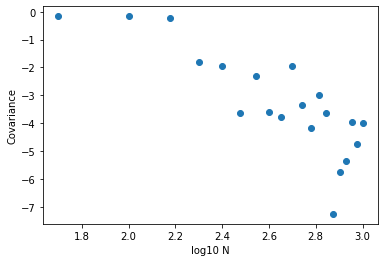

In [95]:
plt.scatter(np.log10(Ns), cov[:,0,1])
plt.xlabel("log10 N")
plt.ylabel("Covariance")
plt.savefig("figures/covariance.svg")

Covariance becomes more negative with higher N since with more susceptibles, the disease can spread faster and more efficiently

## Variance

In [101]:
Ns = np.arange(50, 1050, 50)

mu = 1/75
gam = 1.0
beta = 3.0
eta = 0.02

params = [gam, beta, mu, eta]

model = StochasticSIR(np.zeros(3), params)
var = np.zeros((len(Ns)))
meanI = np.zeros((len(Ns)))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0

    inits = [X0, Y0, Z0]
    model.model[0]=inits
    
    model.simulate(100)
    sol = model.unpack()
    
    var[i] = np.var(sol[:,1])
    meanI[i] = np.mean(sol[:,1])
    model.reset()
    #print(f"{i} finished")

Text(0, 0.5, 'log10 σ')

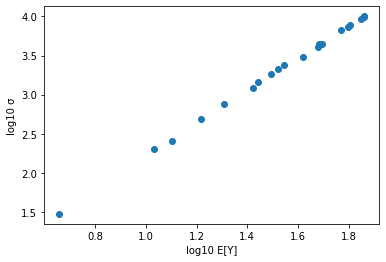

In [109]:
sorted_idxs = np.argsort(meanI)
meanI = np.log10(meanI[sorted_idxs])
var = np.log10(var[sorted_idxs])
plt.scatter(meanI, var)
plt.xlabel("log10 E[Y]")
plt.ylabel("log10 σ")

# 3: Increased Transients

    Increased transients. Stochastic perturbations away from the equilibrium solution
    are countered by the generally convergent behavior of the underlying deterministic
    dynamics. When far from the endemic equilibrium point, these restorative forces
    are usually strong and dominate, so that the model acts much like the deterministice 
    quations. Thus, the dynamics of stochastic models can be conceptualized as
    resulting from random perturbations away from, and transient-like return toward, the
    deterministic attractor
    
    
I.e.: when far from the equilibrium, we will get sharper jumps back towards the equilibrium

In [60]:
N = 150

mu = 1/75
gam = 0.1
beta = 3.0
eta = 0#0.02

params = [gam, beta, mu, eta]


Ys = []
time = []
det = []

Y0 = 100
X0 = N - Y0
Z0 = 0

inits = [X0, Y0, Z0]

model = StochasticSIR(inits, params)

for i in range(10):
    
    model.simulate(300)
    
    sol = model.unpack()
    Ys.append(sol[:,1])
    time.append(model.time)
    
    model.reset()
    
sol = model.solve_deterministic(SIR, (0, 300))#, inits=np.array(inits)/N)
det.append(sol.sol(time[0])[1,:])

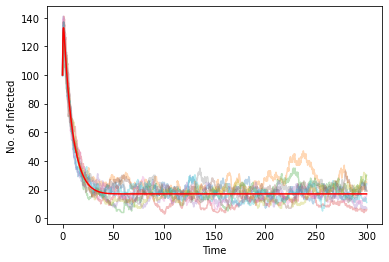

In [68]:
 for i in range(10):
    plt.plot(time[i], Ys[i], alpha=0.3)
plt.plot(time[0], det[0]*N, color="red")
plt.ylabel("No. of Infected")
plt.xlabel("Time")
plt.savefig("figures/transients.svg")

# 4: Stochastic Resonance


    Stochastic resonance. As most SIR-type disease models approach equilibrium in
    a series of decaying epidemics, the increased transient-like dynamics of stochastic
    models leads to oscillations close to the natural frequency (Chapter 2). Thus,
    stochasticity can excite epidemic oscillations around the normal endemic prevalence,
    leading to sustained cycles.


In [14]:
def SIR(t, u, gam, beta, mu):
    
    S, I, R = u
    
    dS = mu - mu*S - beta*S*I
    dI = beta*S*I - mu*I - gam*I
    dR = gam*I - mu*R
    
    return [dS, dI, dR]

In [145]:
N = 150

mu = 1/8
gam = 0.1
beta = 1.0
eta = 0#0.02

params = [gam, beta, mu, eta]


Ys = []
time = []
det = []

Y0 = 10
X0 = N - Y0
Z0 = 50

inits = [X0, Y0, Z0]

model = StochasticSIR(inits, params)


for i in range(10):
    model.simulate(100)

    I = model.unpack()[:,1]
    Ys.append(I)
    time.append(model.time)
    model.reset()
#Ys.append(sol[:,1])
#time.append(model.time)


sol = model.solve_deterministic(SIR, (0, 100))#, inits=np.array(inits)/N)
sol = sol.sol(time[-1])[1,:]
#det.append(sol.sol(time[0])[1,:])

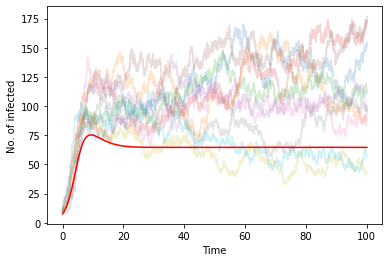

In [151]:
for i in range(10):
    plt.plot(time[i], Ys[i], alpha=0.2)
plt.plot(time[-1], sol*N, color="red")# label="Deterministic")
plt.xlabel("Time")
plt.ylabel("No. of infected")
plt.savefig("figures/stochastic_resonance.svg")

# 5: Extinctions

## 5.1: Average no. of extinctions per year

    A more mathematically pleasing approach is to start the stochastic
    simulations at, or near to, the deterministic equilibrium and measure the average
    time until the population goes extinct—called the “first passage time.” 

In [14]:
N_iters = 25

Ns = np.logspace(1, 5, 20)

mu = 1/50
gam = 0.7
beta = 10.0
eta = 0.02

params = [gam, beta, mu, eta]

extcs = np.zeros(len(Ns))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0
    inits = [X0, Y0, Z0]
    model = StochasticSIR(inits, params)
    for j in range(N_iters):
        model.burn_in(10)
        model.simulate(210)

        
        extcs[i] += len(model.extincts)
        model.reset()
        
    
    extcs[i] /= N_iters
    
np.save("excts", extcs)

KeyboardInterrupt: 

In [98]:
extcs = np.load("excts.npy")
Ns = np.logspace(1, 5, 20)

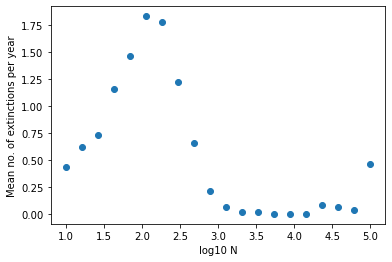

In [101]:
plt.scatter(np.log10(Ns), extcs/200)
plt.xlabel("log10 N")
plt.ylabel("Mean no. of extinctions per year")
plt.savefig("figures/extcs_per_year.svg")

## 5.2: First Passage Time

In [6]:
N_iters = 20

Ns = np.logspace(2, 3, 20)

mu = 1/15
gam = 0.7
beta = 10.0
eta = 0.02

params = [gam, beta, mu, eta]

t_exct = np.zeros(len(Ns))
for (i, N) in enumerate(Ns):
    Y0 = 1
    X0 = N - Y0
    Z0 = 0
    inits = [X0, Y0, Z0]
    
    model = StochasticSIR(inits, params)
    ctr = 1
    for j in range(N_iters):
        model.burn_in(10)
        model.simulate(210)

        if len(model.extincts) > 1:
            t_exct[i] += model.extincts[0]
            ctr += 1
        
        model.__init__(inits, params)
        
    t_exct[i] /= ctr
    print(f"{i+1} of {len(Ns)} done")

#np.save("first_passage", t_exct)

1 of 20 done
2 of 20 done
3 of 20 done
4 of 20 done
5 of 20 done
6 of 20 done
7 of 20 done
8 of 20 done
9 of 20 done
10 of 20 done
11 of 20 done
12 of 20 done
13 of 20 done
14 of 20 done
15 of 20 done
16 of 20 done
17 of 20 done
18 of 20 done
19 of 20 done
20 of 20 done


In [103]:
first_passage = np.load("first_passage.npy")
Ns = np.logspace(2, 5, 20)

In [107]:
first_passage

array([52.66319768, 61.88987281, 85.53821481, 10.34700664, 10.0250929 ,
       10.15130655, 10.02529379, 10.21255555, 10.06773255, 10.06055738,
       10.05999527,         nan, 10.22344407, 10.0469339 , 10.09021342,
       10.05532082, 10.02268351,         nan, 10.1164655 ,         nan])

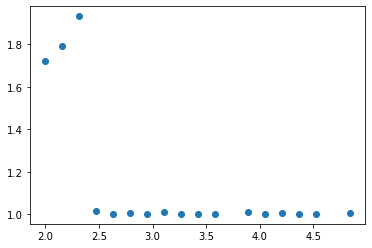

In [106]:
plt.scatter(np.log10(Ns), np.log10(first_passage))

# Part 2: Metapopulation Models

## 2.1: Two subpopulations

In [30]:
a = np.random.random((2, 3))
e, t, y = a[1,:]

In [143]:
class StochasticMetaSIR():
    def __init__(self, inits, gamma, beta, rho):
        self.n_pops = len(inits)
        self.beta = beta     # list/array
        self.gamma = gamma
        self.rho = rho
        
        self.model = np.zeros((self.n_pops, 3))
        for i in range(self.n_pops):
            self.model[i, :] = inits[i]
            
        self.pops = [[(self.model[i,0], self.model[i,1], self.model[i,2])] for i in range(self.n_pops)]
        
    def get_event(self):
        events = np.zeros((self.n_pops, 2))
        
        rates = np.zeros((2, self.n_pops))
        for i in range(self.n_pops):
            X, Y, Z = self.model[i,:]
            N = sum(self.model[i,:])
            
            rates[0, i] = self._lambda(i)
            rates[1, i]  = self.gamma[i]*Y

        dt = -np.log(np.random.random())/np.sum(rates)
        P = np.random.random()*np.sum(rates)
        E = np.min(np.where(np.cumsum(rates) >= P))
                
        return E, dt   
    
    def _lambda(self, i):
        N = np.sum(self.model[i,:])
        return self.beta[i]/N*np.sum(rho[i,:]*self.model[:,1])
    

    def update(self, event):

        pop_id = int(np.ceil((event-1)/2))
        
        if event%2 == 0:
            self.model[pop_id, 0] -= 1
            self.model[pop_id, 1] += 1
        else:
            self.model[pop_id, 1] -= 1
            self.model[pop_id, 2] += 1
            
    def simulate(self, T):
        """ Simulate for T seconds """
        
        t = 0
        while t <= T:
            event, dt = self.get_event()
            self.update(event)
            
            for i in range(self.n_pops):
                self.pops[i].append(tuple(self.model[i,:]))
            
            t += dt
        

In [150]:
inits = [[100, 0, 0], [90, 10, 0]]
gamma = [0.4, 0.5]
beta = [3.0, 5.0]

rho = np.array([1.0, 0.2, 0.5, 1]).reshape(-1, 2)

test = StochasticMetaSIR(inits, gamma, beta, rho)

In [151]:
test.simulate(100)
test.pops

<ipython-input-143-ba6b27465509>:25: RuntimeWarning: divide by zero encountered in double_scalars
  dt = -np.log(np.random.random())/np.sum(rates)


[[(100.0, 0.0, 0.0),
  (100.0, 0.0, 0.0),
  (100.0, 0.0, 0.0),
  (100.0, 0.0, 0.0),
  (100.0, -1.0, 1.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (100.0, -2.0, 2.0),
  (99.0, -1.0, 2.0),
  (99.0, -1.0, 2.0),
  (98.0, 0.0, 2.0),
  (97.0, 1.0, 2.0)],
 [(90.0, 10.0, 0.0),
  (90.0, 9.0, 1.0),
  (90.0, 8.0, 2.0),
  (90.0, 7.0, 3.0),
  (90.0, 7.0, 3.0),
  (90.0, 7.0, 3.0),
  (90.0, 6.0, 4.0),
  (90.0, 5.0, 5.0),
  (90.0, 4.0, 6.0),
  (90.0, 3.0, 7.0),
  (90.0, 2.0, 8.0),
  (90.0, 1.0, 9.0),
  (90.0, 1.0, 9.0),
  (90.0, 0.0, 10.0),
  (90.0, 0.0, 10.0),
  (90.0, 0.0, 10.0)]]

In [252]:
rho = [1, 0.1]
beta = [3.0, 3.0]
gam = [1.0, 1.0]
N = [100, 100]

Y0 = [1, 1]
X0 = [N[0]-Y0[0], N[0]-Y0[1]]

tspan = (0, 100)

params = (gam, beta, rho)

u0 = np.array([X0[0], Y0[0],
               X0[1], Y0[1]])

In [259]:
u0[1::2] + u0[0::2]

array([100, 100])

In [263]:
solve_ivp(MetaSIR, tspan, u0, args=params, vectorized=True)

ValueError: operands could not be broadcast together with shapes (8,) (4,) 

In [ ]:
class MetaSIR():
    def __init__(self, npops, inits, paramas):
        
        self.npops = npops
        self.inits = inits
        self.params = params

        self.model = [inits]
        self.time = []